# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import smdebug
import boto3
import os
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role

bucket = "sagemaker-us-east-1-457357529781"
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
data = "s3://{}/{}/".format(bucket, "dogImages")
output = "s3://{}/{}/".format(bucket, "output")
model_dir = "s3://{}/{}/".format(bucket, "model")
os.environ["DEFAULT_S3_BUCKET"] = bucket
os.environ['SM_CHANNEL_TRAIN']= data 
os.environ['SM_OUTPUT_DATA_DIR']= output
os.environ['SM_MODEL_DIR']= model_dir

print("Default Bucket: {}".format(bucket))

Default Bucket: sagemaker-us-east-1-457357529781


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

this data set is for different breed if dogs and our task is to build a deep learning model able to classify between these categories

In [272]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# !unzip dogImages.zip

In [5]:
# Sync images with s3
import os
!aws s3 sync ./dogImages/train s3://sagemaker-us-east-1-457357529781/data/dogImages/train/ > /dev/null
!aws s3 sync ./dogImages/test s3://sagemaker-us-east-1-457357529781/data/dogImages/test/ > /dev/null
!aws s3 sync ./dogImages/valid s3://sagemaker-us-east-1-457357529781/data/dogImages/valid/ > /dev/null
;

''

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [6]:
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

In [106]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.01, 0.1),
    "batch_size": CategoricalParameter([256, 512]),
    "epochs": IntegerParameter(2,3)
}

In [107]:
objective_metric_name = "test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "test loss", "Regex": "Loss On testing_data: ([0-9\\.]+)"}]

In [108]:
#TODO: Create estimators for your HPs

estimator = PyTorch(entry_point="./hpo.py",
                    framework_version="1.8",
                    py_version="py36",
                    role=get_execution_role(),
                    instance_count = 1,
                    instance_type="ml.m5.large"
                   )# TODO: Your estimator here

tuner = HyperparameterTuner(estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            max_jobs=4,
                            max_parallel_jobs=4,
                            objective_type = objective_type,)
                            
 

In [109]:
tuner.fit({
    'train': "s3://sagemaker-us-east-1-457357529781/data/dogImages/train",
'valid': "s3://sagemaker-us-east-1-457357529781/data/dogImages/valid",
'test': "s3://sagemaker-us-east-1-457357529781/data/dogImages/test"}
              , wait=True)


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [22]:
# self.files = [os.path.join(directory, f) for f in os.listdir(directory)]

In [23]:
# TODO: Fit your HP Tuner
# tuner.fit(inputs="s3://sagemaker-us-east-1-457357529781/data/dogImages" ,wait=True)
 # TODO: Remember to include your data channels

In [112]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()#TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


lr_b = float(best_estimator.hyperparameters()["lr"])
epochs_b = int(best_estimator.hyperparameters()['epochs'])
#batch_size_b = int(best_estimator.hyperparameters()['batch_size']
batch_size_b = int(best_estimator.hyperparameters()['batch_size'].replace('"', ""))


hyperparameters_best = {
    "lr": lr_b,
    "batch_size": batch_size_b,
    "epochs": epochs_b
}


2022-10-25 11:37:46 Starting - Preparing the instances for training
2022-10-25 11:37:46 Downloading - Downloading input data
2022-10-25 11:37:46 Training - Training image download completed. Training in progress.
2022-10-25 11:37:46 Uploading - Uploading generated training model
2022-10-25 11:37:46 Completed - Resource released due to keep alive period expiry


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [173]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import (
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]
# ok
profiler_config = ProfilerConfig(
    #system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)
debugger_config=DebuggerHookConfig(
    collection_configs=collection_configs
)

In [174]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.large",
    entry_point="train_model.py",
    framework_version="1.4.0",
    py_version="py3",
    hyperparameters=hyperparameters_best,
    profiler_config=profiler_config, 
    debugger_hook_config=debugger_config, 
    rules=rules
) # TODO: Your estimator here

In [175]:
estimator.fit({
    'train': "s3://sagemaker-us-east-1-457357529781/data/dogImages/train",
'valid': "s3://sagemaker-us-east-1-457357529781/data/dogImages/valid",
'test': "s3://sagemaker-us-east-1-457357529781/data/dogImages/test"}
              , wait=True)

2022-10-25 23:48:27 Starting - Starting the training job...
2022-10-25 23:48:57 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2022-10-25 23:50:18 Downloading - Downloading input data...............
2022-10-25 23:52:59 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-10-25 23:52:49,119 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-10-25 23:52:49,123 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-10-25 23:52:49,144 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-10-25 23:52:49,152 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-10-25 23:52:49,692

In [176]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
training_job_name = estimator.latest_training_job.name
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-10-26 00:49:32.807 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-457357529781/pytorch-training-2022-10-25-23-48-26-540/debug-output
[2022-10-26 00:49:33.160 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 1653 more expected)', IncompleteRead(0 bytes read, 1653 more expected)) while reading s3://sagemaker-us-east-1-457357529781/pytorch-training-2022-10-25-23-48-26-540/debug-output/index/000000000/000000000000_worker_0.json . Will retry now


In [177]:
from smdebug import modes
trial.tensor('CrossEntropyLoss_output_0').values(mode=modes.TRAIN)
tensor_name = "CrossEntropyLoss_output_0"
from smdebug.core.modes import ModeKeys

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

get_data(trial, tensor_name, mode=ModeKeys.TRAIN)

[2022-10-26 00:51:55.436 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-10-26 00:51:56.461 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO trial.py:210] Loaded all steps


([0, 10, 20, 30, 40, 50, 60, 70, 80],
 [array(5.1706896, dtype=float32),
  array(11.483621, dtype=float32),
  array(7.116975, dtype=float32),
  array(5.102078, dtype=float32),
  array(2.7236536, dtype=float32),
  array(2.087777, dtype=float32),
  array(1.9393463, dtype=float32),
  array(1.8603535, dtype=float32),
  array(1.5432253, dtype=float32)])

In [178]:
# TODO: Plot a debugging output.
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


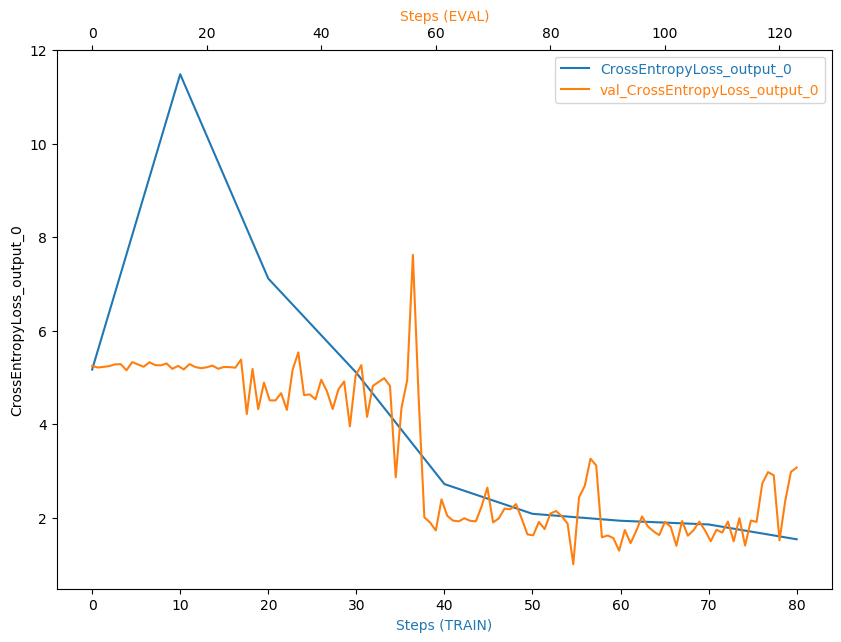

In [179]:
plot_tensor(trial, "CrossEntropyLoss_output_0") 


**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
may be at step number 35 the validation loss increased and started to decrease again if it keept increasing that means overfiting so i would use dropout layers and batch normalization to avoid overfitting 

**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?
the error would be decreaseing the training loss while increaseing the validation lose which mean overfitting, i can fic it by some data augmentation, adding dropout and batchnormalization layers

In [261]:
estimator.output_path

's3://sagemaker-us-east-1-457357529781/'

In [ ]:
estimator.output_path

In [ ]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [135]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-457357529781/pytorch-training-2022-10-25-13-02-05-031/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-457357529781/pytorch-training-2022-10-25-13-02-05-031/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-457357529781/pytorch-training-2022-10-25-13-02-05-031/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-457357529781/pytorch-training-2022-10-25-13-02-05-031/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-ea

In [263]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [265]:
profiler_report_name

'ProfilerReport'

In [271]:
import IPython
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")


## Model Deploying

In [202]:
import torch

In [269]:
estimator.model_data

's3://sagemaker-us-east-1-457357529781/pytorch-training-2022-10-25-23-48-26-540/output/model.tar.gz'

In [188]:
estimator.latest_job_profiler_artifacts_path

<bound method EstimatorBase.latest_job_profiler_artifacts_path of <sagemaker.pytorch.estimator.PyTorch object at 0x7efd37a323d0>>

In [151]:
estimator.model_data

's3://sagemaker-us-east-1-457357529781/pytorch-training-2022-10-25-13-02-05-031/output/model.tar.gz'

In [208]:
estimator.input_mode

'File'

In [211]:
# this is get error when i try to 
# predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m5.large')\

-----!

In [218]:
# from smdebug import modes
# trial.tensor('CrossEntropyLoss_output_0').values(mode=modes.TRAIN)
# tensor_name = "CrossEntropyLoss_output_0"

In [219]:
# def get_data(trial, tname, mode):
#     tensor = trial.tensor(tname)
#     steps = tensor.steps(mode=mode)
#     vals = []
#     for s in steps:
#         vals.append(tensor.value(s, mode=mode))
#     return steps, vals

# get_data(trial, tensor_name, mode=ModeKeys.TRAIN)

In [236]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

#model_data_artifacts = estimator.model_data
#For avoiding waiting:
model_data_artifacts = estimator.model_data
print("Model data artifacts saved at:\n", model_data_artifacts)

#We need to define the serializer and deserializer that we will be using as default for our Prediction purposes
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super( ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )


type(ImgPredictor)


Model data artifacts saved at:
 s3://sagemaker-us-east-1-457357529781/pytorch-training-2022-10-25-23-48-26-540/output/model.tar.gz


abc.ABCMeta

In [237]:
pytorch_model = PyTorchModel( model_data = model_data_artifacts,
                            role = get_execution_role(),
                             entry_point= "inference.py",
                             py_version = "py36",
                             framework_version = "1.6",
                            predictor_cls = ImgPredictor
                            )

In [273]:
predictor = pytorch_model.deploy( initial_instance_count = 1, instance_type = "ml.m5.large")

------!

the expected beerd class : 16


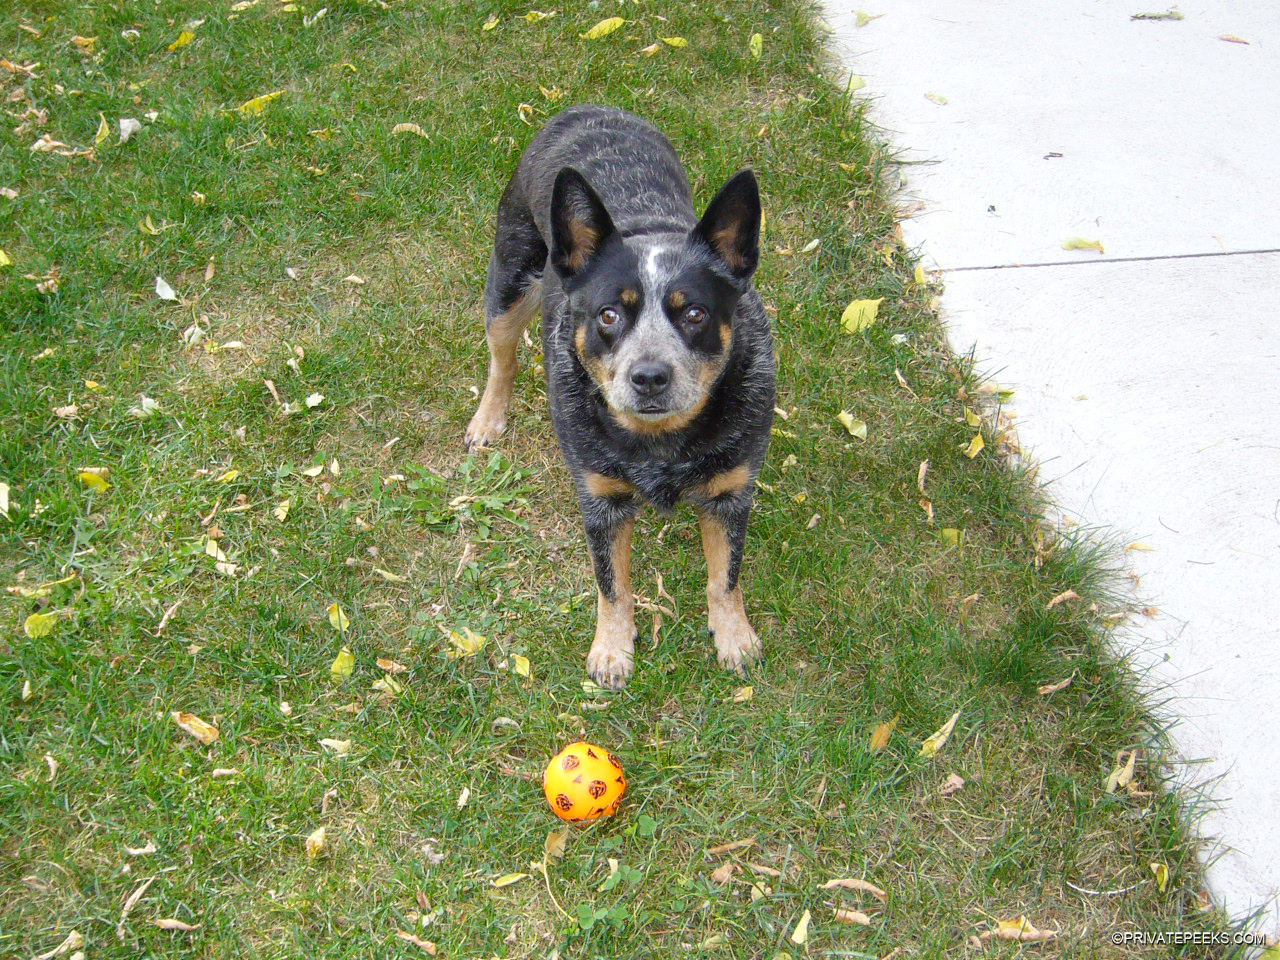

the predicted beerd class : [11]


In [242]:
from PIL import Image
import io
import os
import numpy as np

test_file_path = './dogImages/test/011.Australian_cattle_dog/Australian_cattle_dog_00727.jpg'
expected_breed_category = 16
print(f"the expected beerd class : {expected_breed_category}")
with open(test_file_path , "rb") as f:
    payload = f.read()
    
    display(Image.open(io.BytesIO(payload)))

    response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})

    predicted_dog_breed = np.argmax(response,1) + 1 #index starts in 0 and breeds start in 1
    
    print(f"the predicted beerd class : {predicted_dog_breed}")

In [274]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()